### 청와대 국민청원 데이터에서 각 분류별 Top1 추출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")
import datetime as dt
### 세종사전 실행
from konlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
twitter = Twitter()

In [2]:
df = pd.read_excel("test/test_기타.xlsx")
df
# df.Date = pd.to_datetime(df.Date)

,Date,Title
0,2020-04-27,"""승리 취하지 마라"" 민주당 초선 워크숍 원내대표 당대표 후보들 '눈도장'"
1,2020-04-27,"여야, 내일 ‘긴급재난지원금 추경’ 본회의 처리 합의"
2,2020-04-27,여당 원내대표 경선 3파전 정성호 “협치” 김태년 전해철은 “성과”
3,2020-04-27,“열린우리당 트라우마 반복 안돼 진실 성실 절실 ‘3실’ 지켜달라”
4,2020-04-27,"민주당, 나흘 만에 오거돈 제명 ‘뒷북’ 통합당, 보선 여당 무공천 촉구 ‘잿밥’"
...,...,...
16680,2020-01-26,우한폐렴 국민청원
16681,2020-01-26,여러분 진짜 진짜 ㅠㅠㅠㅠ 지금 국민
16682,2020-01-26,윤석열 총장 수사팀을 해체하지 말라 국민청원
16683,2020-01-26,중국인 입국 금지 요청 대한민국 청와대 국민 청원


## 키워드 변경 함수

In [3]:
def rep_keyword(before, after):
    ind = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].index
    df.iloc[ind,1] = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].str.replace(before,after,case = False)

In [4]:
rep_keyword("n번방","엔번방")
rep_keyword("N번방","엔번방")

In [5]:
from string import punctuation
df2 = list(df.Title)

In [6]:
def strip_punc(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for sent in df2:
    clean_df = strip_punc(sent)
    clean_title.append(clean_df)

clean_title[0:3]

['승리 취하지 마라 민주당 초선 워크숍 원내대표 당대표 후보들 눈도장',
 '여야 내일 ‘긴급재난지원금 추경’ 본회의 처리 합의',
 '여당 원내대표 경선 3파전 정성호 “협치” 김태년 전해철은 “성과”']

In [7]:
from konlpy.tag import Kkma
kkma = Kkma()
import re
import time
import datetime
start = time.time()

dataset = []
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\s]','',clean_title[i])))
    
sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times)

0:04:11


In [8]:
from gensim import corpora, models
import gensim

In [9]:
high_score_reviews = dataset

In [10]:
high_score_reviews = [[y for y in x if not len(y)==1]
                     for x in high_score_reviews]
diction = corpora.Dictionary(high_score_reviews)
corpus = [diction.doc2bow(text) for text in high_score_reviews]


In [11]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = high_score_reviews, dictionary = diction,
                                        topn = 10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


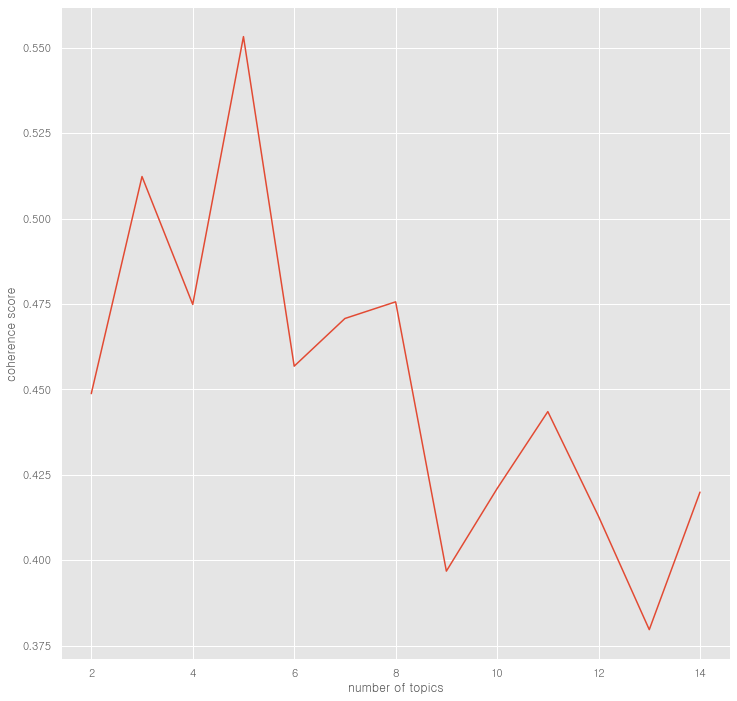

In [12]:
x = range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [13]:
import matplotlib.pyplot as plt
perplexity_values = []
for i in range(2, 20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

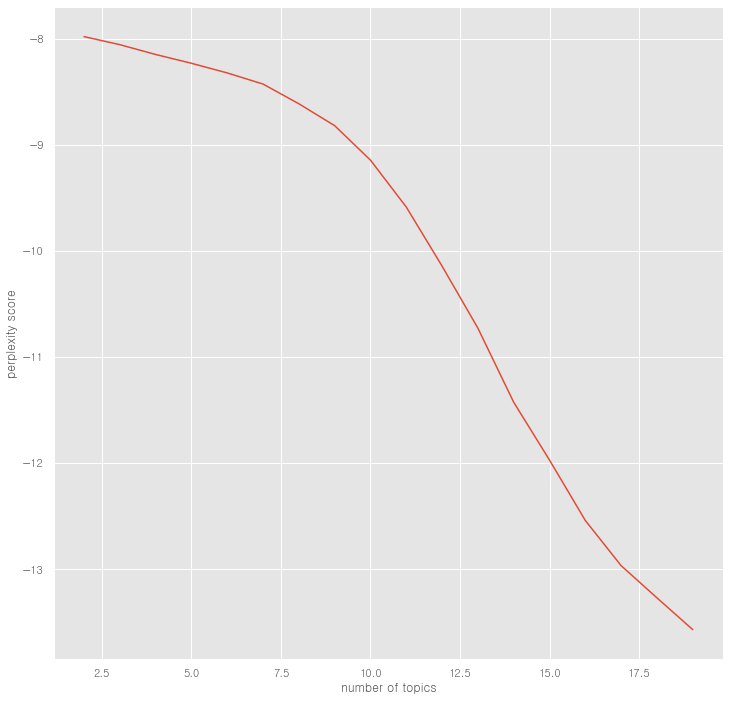

In [14]:
x = range(2,20)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [15]:
## 토픽 개수 7개 아니면 11개가 적당할거 같다.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= 11, alpha = 0.1, id2word= diction)

In [17]:
ldamodel.print_topics(num_words = 20)

[(0,
  '0.083*"입국" + 0.046*"대한" + 0.044*"민국" + 0.044*"대한민국" + 0.042*"국민" + 0.036*"중국인" + 0.027*"대통령" + 0.023*"촉구" + 0.023*"코로나" + 0.023*"중국" + 0.021*"진자" + 0.021*"자랑" + 0.020*"다음" + 0.017*"청와대" + 0.017*"한국" + 0.016*"주세" + 0.015*"정부" + 0.014*"사망" + 0.012*"나라" + 0.011*"교주"'),
 (1,
  '0.102*"돌파" + 0.079*"관련" + 0.026*"참여" + 0.021*"박사" + 0.018*"국민" + 0.015*"서명" + 0.014*"영상" + 0.014*"청원" + 0.013*"소득" + 0.012*"공개" + 0.011*"사실" + 0.010*"확인" + 0.010*"게이트" + 0.010*"박사방" + 0.010*"기본" + 0.010*"이름" + 0.009*"논란" + 0.009*"만명" + 0.009*"하루" + 0.008*"사용"'),
 (2,
  '0.032*"신상" + 0.031*"부탁" + 0.028*"공개" + 0.024*"사건" + 0.023*"누리" + 0.019*"질병" + 0.018*"판사" + 0.016*"연대" + 0.015*"추미애" + 0.014*"때문" + 0.013*"링크" + 0.013*"연합" + 0.012*"신상공개" + 0.012*"관심" + 0.011*"배우" + 0.011*"자살사건" + 0.011*"단역배우" + 0.011*"단역" + 0.011*"청와대" + 0.010*"시간"'),
 (3,
  '0.112*"신천지" + 0.033*"국민" + 0.023*"고발" + 0.019*"퇴출" + 0.017*"수사" + 0.015*"요구" + 0.013*"민족" + 0.011*"단독" + 0.009*"서울" + 0.009*"인터뷰" + 0.008*"정부" + 0.008*"시다" + 0.008*"내용" 

In [18]:
import pyLDAvis

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float

In [19]:
from gensim.models import LdaModel # To use the LDA model

import pyLDAvis.gensim # To visualise LDA model effectively

import pandas as pd


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, diction)
vis

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.359430 -0.129690       1        1  28.412329
0      0.144002  0.193961       2        1  11.592679
3     -0.058895 -0.063524       3        1   7.842810
4      0.007712 -0.016611       4        1   7.443449
6     -0.079435  0.009586       5        1   7.243241
8      0.017716  0.287353       6        1   7.233214
9     -0.115108 -0.020957       7        1   6.723295
7     -0.060667 -0.032351       8        1   6.597208
2     -0.072694 -0.073349       9        1   6.209874
1     -0.009126 -0.157445      10        1   5.748845
5     -0.132934  0.003027      11        1   4.953056, topic_info=      Term          Freq         Total Category  logprob  loglift
6767  국민청원   9495.000000   9495.000000  Default  30.0000  30.0000
821     청원  10435.000000  10435.000000  Default  29.0000  29.0000
2294    금지   1618.000000   1618.000000  Default  28.0000  28.0000
2536    요청   1480.000000   1480.000000  Default  27.0000  27.0000
224     재인   1689.000000   1689.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
3324    하루     71.011060    304.502434  Topic11  -4.8133   1.5493
50     코로나     91.892193   2123.031055  Topic11  -4.5555  -0.1348
259    법무부     35.564820     60.238720  Topic11  -5.5048   2.4782
48     대통령     63.513140   2343.954991  Topic11  -4.9249  -0.6032
123     국민     36.518791  11043.119311  Topic11  -5.4783  -2.7066

[595 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4225     10  0.965198    가열
1702     10  0.978840    가족
1583      3  0.966620    가지
3238      8  0.992221    가짜
3239      8  0.978395  가짜뉴스
...     ...       ...   ...
1129      4  0.534833    회의
1129      5  0.075064    회의
1129      6  0.009383    회의
1129      8  0.075064    회의
1129     10  0.178278    회의

[1166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 4, 5, 7, 9, 10, 8, 3, 2, 6])

In [20]:
kk = ldamodel.show_topic(1,topn = 80000)
type(ldamodel.show_topic)
kk2 = pd.DataFrame(kk)
kk2
#kk2.to_csv("test0911_1.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1
0,돌파,0.102298
1,관련,0.079174
2,참여,0.026448
3,박사,0.021194
4,국민,0.018016
...,...,...
18728,칼럼여론조사,0.000010
18729,검증토지공개념,0.000010
18730,내수부양,0.000010
18731,김정은과,0.000010


In [21]:
def make_topictable_per_doc(ldamodel,corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key = lambda x: (x[1]), reverse = True)
        
        
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num),round(prop_topic,4),topic_list]),
                                                ignore_index= True)
            else:
                break
                    
    return(topic_table)

                

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
topictable = make_topictable_per_doc(ldamodel,corpus)
topictable = topictable.reset_index()
topictable.columns = ["문서 번호", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]
topictable["문서 내용"] = df.Title
topictable = topictable.loc[:,["문서 번호", "문서 내용", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]]
topictable[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,문서 내용,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,"""승리 취하지 마라"" 민주당 초선 워크숍 원내대표 당대표 후보들 '눈도장'",9.0,0.4634,"[(3, 0.44901428), (9, 0.46343043)]"
1,1,"여야, 내일 ‘긴급재난지원금 추경’ 본회의 처리 합의",10.0,0.4915,"[(7, 0.4273354), (10, 0.4915047)]"
2,2,여당 원내대표 경선 3파전 정성호 “협치” 김태년 전해철은 “성과”,3.0,0.5228,"[(0, 0.01027069), (1, 0.010271568), (2, 0.0102..."
3,3,“열린우리당 트라우마 반복 안돼 진실 성실 절실 ‘3실’ 지켜달라”,3.0,0.7253,"[(0, 0.013717006), (1, 0.013717011), (2, 0.013..."
4,4,"민주당, 나흘 만에 오거돈 제명 ‘뒷북’ 통합당, 보선 여당 무공천 촉구 ‘잿밥’",4.0,0.4321,"[(4, 0.432139), (5, 0.17002028), (6, 0.33209935)]"
5,5,"문 대통령 “코로나19 위기, 남북 협력에 새 기회”",4.0,0.8591,"[(0, 0.014089948), (1, 0.014087141), (2, 0.014..."
6,6,트럼프의 ‘변칙 플레이’ 끝나자 ‘북 미 신뢰 부족’ 현실 드러나,6.0,0.8423,"[(0, 0.015773643), (1, 0.015771424), (2, 0.015..."
7,7,동해북부선 강릉 ~ 제진 구간 53년 만에 복원 ‘시동’,3.0,0.4061,"[(0, 0.013297597), (1, 0.013297602), (2, 0.013..."
8,8,"고기영 동부지검장, 법무차관에 임명",0.0,0.7910,"[(0, 0.79103696), (1, 0.108800314), (2, 0.0111..."
9,9,"‘피의자’ 오거돈, “소환일 검토” 또 다른 성추행 사건도 수사",6.0,0.5767,"[(1, 0.11180706), (2, 0.2327783), (6, 0.5767414)]"


In [22]:
# topictable.to_csv("test0911_2.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
